In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import BM25Recommender
from src.evaluation import evaluate_retriever

df = pd.read_pickle("../data/processed/en_movies_processed.pkl")
test_set = df.sample(2000, random_state=42)

In [2]:
variants = [
    {"name": "baseline", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "no_lemma", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": False, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "keep_stop", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": False, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "bigrams", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 3, "use_alpha_filter": True}},
    {"name": "min_len_2", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 2, "use_alpha_filter": True}},
    {"name": "min_len_4", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 4, "use_alpha_filter": True}},
    {"name": "no_alpha", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": False}},
    {"name": "no_lemma_keep_stop", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": False, "remove_stopwords": False, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "no_lemma_bigrams", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": False, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 3, "use_alpha_filter": True}},
    {"name": "bigrams_min2", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 2, "use_alpha_filter": True}},
    {"name": "no_alpha_min2", "params": {"k1": 1.5, "b": 0.75, "use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 2, "use_alpha_filter": False}},
]

In [ ]:
results = []

for variant in variants:
    retriever = BM25Recommender(df, **variant['params'])
    retriever.fit()
    scores = evaluate_retriever(retriever, test_set, k_values=[5, 10, 20])

    results.append({
        "variant": variant['name'],
        "variant_name": retriever.get_variant_name(),
        "k1": variant['params']['k1'],
        "b": variant['params']['b'],
        **scores
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('precision@5', ascending=False)

In [4]:
print(df_results[['variant', 'k1', 'b', 'precision@5', 'jaccard@5', 'content_div@5', 'query_time_ms']].to_string(index=False))
df_results.to_csv('../data/results/bm25_eval.csv', index=False)

           variant  k1    b  precision@5  jaccard@5  content_div@5  query_time_ms
         min_len_2 1.5 0.75       0.6880   0.303833       0.764817       3.252310
      bigrams_min2 1.5 0.75       0.6880   0.303833       0.764817       4.050188
     no_alpha_min2 1.5 0.75       0.6880   0.304055       0.764422       4.459266
          no_alpha 1.5 0.75       0.6875   0.303919       0.764510       3.019349
          baseline 1.5 0.75       0.6869   0.303667       0.764868       3.174072
           bigrams 1.5 0.75       0.6869   0.303667       0.764868       3.406926
         min_len_4 1.5 0.75       0.6823   0.302337       0.770102       2.986207
          no_lemma 1.5 0.75       0.6817   0.300868       0.768042       3.009935
  no_lemma_bigrams 1.5 0.75       0.6817   0.300868       0.768042       2.853235
         keep_stop 1.5 0.75       0.6804   0.297389       0.776388       4.291536
no_lemma_keep_stop 1.5 0.75       0.6718   0.291918       0.780848       4.047106


In [ ]:
baseline_prec5 = df_results[df_results['variant'] == 'baseline']['precision@5'].values[0]
df_results['delta_prec@5'] = df_results['precision@5'] - baseline_prec5

print(f"\nBaseline: {baseline_prec5:.3f}")
print(f"Best: {df_results.iloc[0]['variant']} ({df_results.iloc[0]['precision@5']:.3f})")
print(f"Range: {df_results['precision@5'].min():.3f} - {df_results['precision@5'].max():.3f}")


Baseline: 0.687
Best: min_len_2 (0.688)
Range: 0.672 - 0.688


In [27]:
best = df_results.iloc[0]
best

variant                                                  min_len_2
variant_name      bm25_k1.5_b0.75_lemma_no_stop_unigram_min2_alpha
k1                                                             1.5
b                                                             0.75
precision@5                                                  0.688
precision@10                                               0.66755
precision@20                                              0.651675
jaccard@5                                                 0.303833
jaccard@10                                                0.282863
jaccard@20                                                0.265823
content_div@5                                             0.764817
content_div@10                                            0.789963
content_div@20                                            0.807034
query_time_ms                                              3.25231
delta_prec@5                                                0.

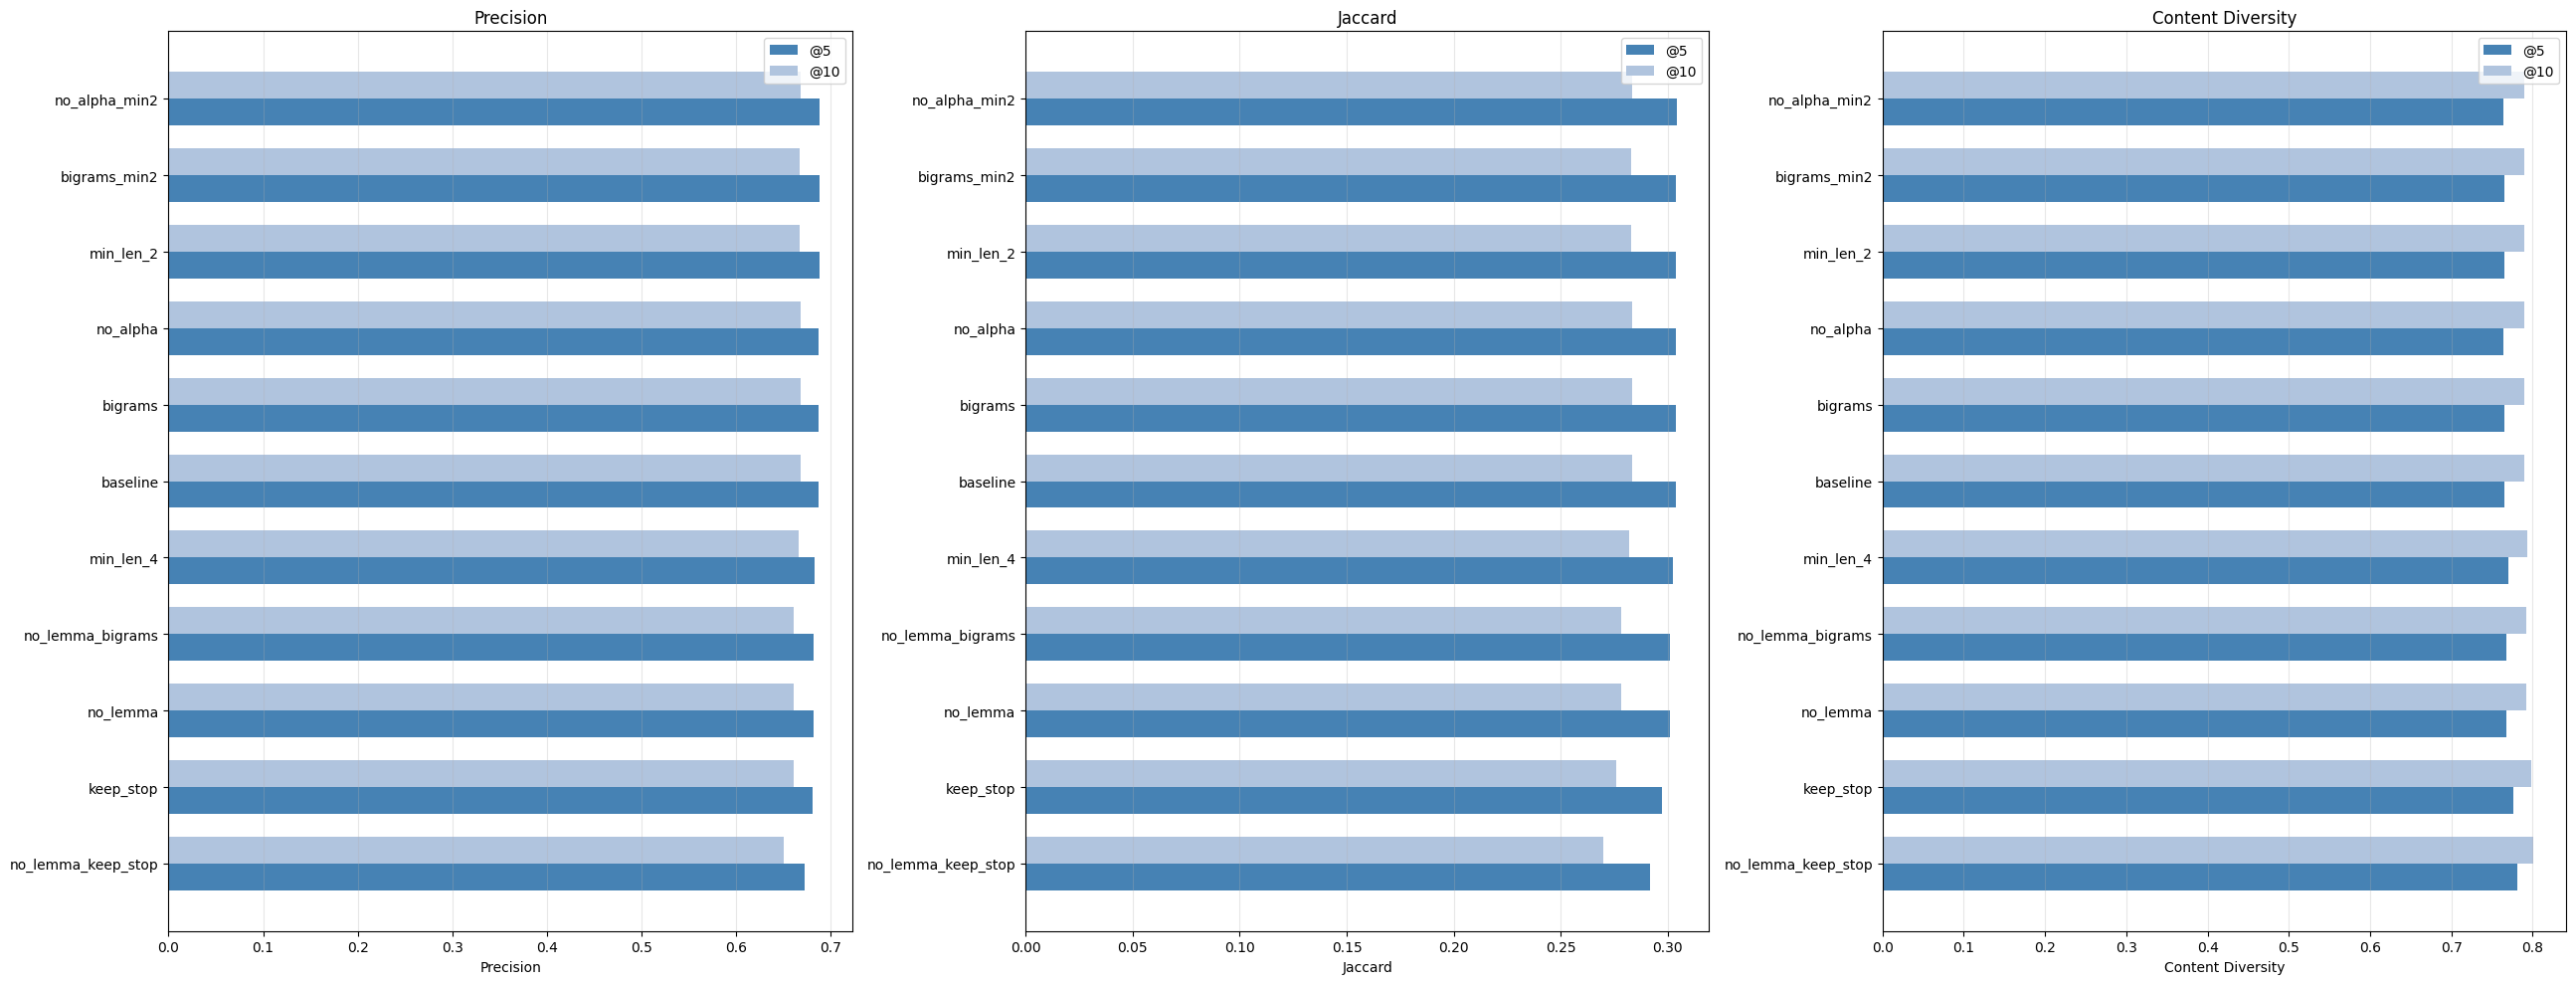

In [28]:
df_sorted = df_results.sort_values('precision@5', ascending=True)
variants = df_sorted['variant'].values
y = np.arange(len(variants))
height = 0.35

fig, axes = plt.subplots(1, 3, figsize=(26, 10))

ax = axes[0]
ax.barh(y - height/2, df_sorted['precision@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['precision@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Precision')
ax.set_title('Precision')
ax.legend()
ax.grid(axis='x', alpha=0.3)

ax = axes[1]
ax.barh(y - height/2, df_sorted['jaccard@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['jaccard@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Jaccard')
ax.set_title('Jaccard')
ax.legend()
ax.grid(axis='x', alpha=0.3)

ax = axes[2]
ax.barh(y - height/2, df_sorted['content_div@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['content_div@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Content Diversity')
ax.set_title('Content Diversity')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/bm25_eval.png', dpi=150, bbox_inches='tight')
plt.show()